In [272]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

### Load data.

In [212]:
df = pickle.load(open("../datasets/train.p", "rb"))

In [213]:
df.head()

,temperature,humidity,light,co2,humidity_ratio,occupancy
date,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:52:00,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [214]:
df.describe()

,temperature,humidity,light,co2,humidity_ratio,occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8143 entries, 2015-02-04 17:51:00 to 2015-02-10 09:33:00
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temperature     8143 non-null   float64
 1   humidity        8143 non-null   float64
 2   light           8143 non-null   float64
 3   co2             8143 non-null   float64
 4   humidity_ratio  8143 non-null   float64
 5   occupancy       8143 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 445.3 KB


In [216]:
df.index

DatetimeIndex(['2015-02-04 17:51:00', '2015-02-04 17:52:00',
               '2015-02-04 17:53:00', '2015-02-04 17:54:00',
               '2015-02-04 17:55:00', '2015-02-04 17:56:00',
               '2015-02-04 17:57:00', '2015-02-04 17:58:00',
               '2015-02-04 17:59:00', '2015-02-04 18:00:00',
               ...
               '2015-02-10 09:24:00', '2015-02-10 09:25:00',
               '2015-02-10 09:26:00', '2015-02-10 09:27:00',
               '2015-02-10 09:28:00', '2015-02-10 09:29:00',
               '2015-02-10 09:30:00', '2015-02-10 09:31:00',
               '2015-02-10 09:32:00', '2015-02-10 09:33:00'],
              dtype='datetime64[ns]', name='date', length=8143, freq=None)

### Augumented Dickey-Fuller Test

- *Null Hypothesis (H0)*: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- *Alternate Hypothesis (H1)*: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.  
  
*p-value > 0.05*: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.  
*p-value <= 0.05*: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.  

*Test Statistic > Critical Value at 1%*: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.  
*Test Statistic <= Critical Value at 1%*: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [217]:
# https://machinelearningmastery.com/time-series-data-stationary-python/

In [218]:
def check_adf(ts):
    adf = adfuller(ts, autolag='AIC')
    adf_series = pd.Series(adf[0:4], index=['Test Statistic','p-value', 'Lags Used', 'Observations Used'])
    adf_series = adf_series.map(lambda x: round(x,4))
    adf_series.index.insert(0, 'Critical Values')
    adf_series['Critical Value at 1%'] = adf[4]['1%']
    return adf_series

### Plot the original values of a feature compared to the mean and standard deviation, and check they are constant.

In [219]:
def check_mean_std(ts, feature):
    rol_mean = ts.rolling(60).mean()
    rol_std = ts.rolling(60).std()
    plt.figure(figsize=(10,6))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rol_mean, color='black', label='Rolling Mean')
    std = plt.plot(rol_std, color='green', label = 'Rolling Std')
    plt.xlabel('Time')
    plt.ylabel('Mean ' + feature)
    plt.title('Rolling Mean & Standard Deviation for ' + feature)
    plt.legend()
    plt.show()

### Check seasonality and create stationary features, where needed.
- check if the mean is constant
- check if the variance is constant
- check if the test statistic is less than the critical value at 1%

If yes to all three above, then the data is stationary.  
I will create a summary dataframe of the stationary features, adf.

In [220]:
adf = pd.DataFrame(columns = ['Feature Name', 'Test Statistic','p-value', 'Lags Used', 'Observations Used', 'Critical Value at 1%'])

### Temperature.

In [221]:
# is the Test Statistic value less than the 1% critical value? Yes
ts = df['temperature'].dropna()
check_adf(ts)

Test Statistic            -2.694400
p-value                    0.075000
Lags Used                 21.000000
Observations Used       8121.000000
Critical Value at 1%      -3.431155
dtype: float64

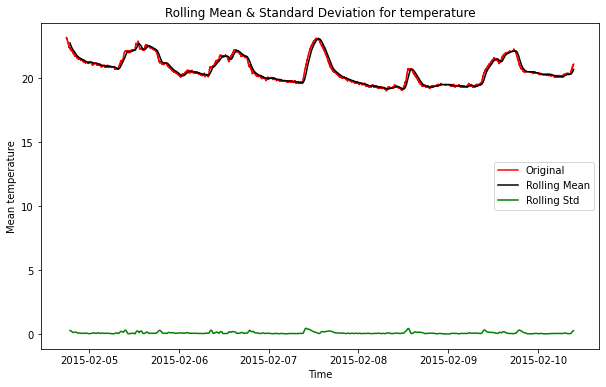

In [222]:
# is the mean constant? No
# is the variance constant? Yes
check_mean_std(ts, 'temperature')

In [223]:
ts = df['temperature']
ts_diff = ts.diff()

In [224]:
# is the Test Statistic value less than the 1% critical value? Yes
adf_series = check_adf(ts_diff.dropna())
adf_series

Test Statistic           -12.058600
p-value                    0.000000
Lags Used                 20.000000
Observations Used       8121.000000
Critical Value at 1%      -3.431155
dtype: float64

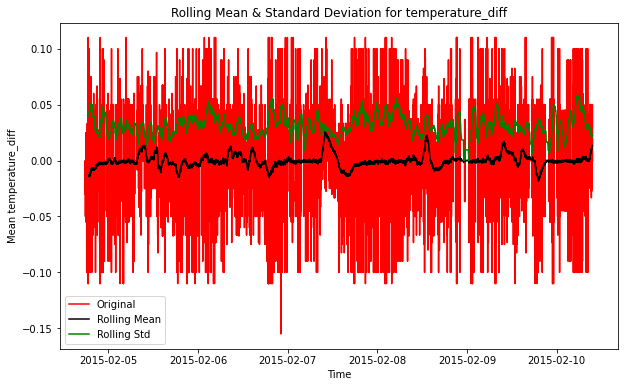

In [225]:
# is the mean constant? Yes
# is the variance constant? Yes
check_mean_std(ts_diff, 'temperature_diff')

In [226]:
adf_series.index.insert(0, 'Feature Name')
adf_series['Feature Name'] = 'temperature_diff'
adf = adf.append(adf_series, ignore_index=True)

### Humidity.

In [227]:
# is the Test Statistic value less than the 1% critical value? No
ts = df['humidity'].dropna()
check_adf(ts)

Test Statistic            -0.751600
p-value                    0.832900
Lags Used                 37.000000
Observations Used       8105.000000
Critical Value at 1%      -3.431157
dtype: float64

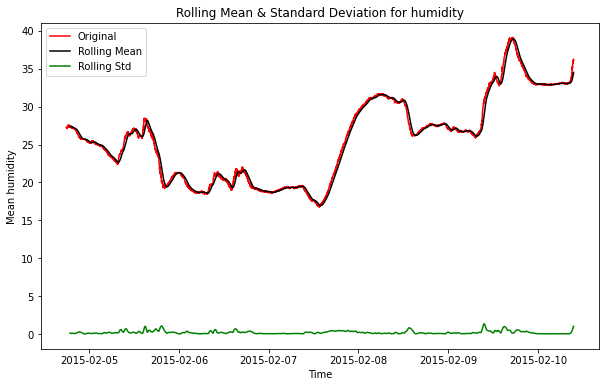

In [228]:
# is the mean constant? No
# is the variance constant? Yes
check_mean_std(ts, 'humidity')

In [229]:
ts = df['humidity']
ts_diff = ts.diff()

In [230]:
# is the Test Statistic value less than the 1% critical value? Yes
adf_series = check_adf(ts_diff.dropna())
adf_series

Test Statistic            -7.697800
p-value                    0.000000
Lags Used                 36.000000
Observations Used       8105.000000
Critical Value at 1%      -3.431157
dtype: float64

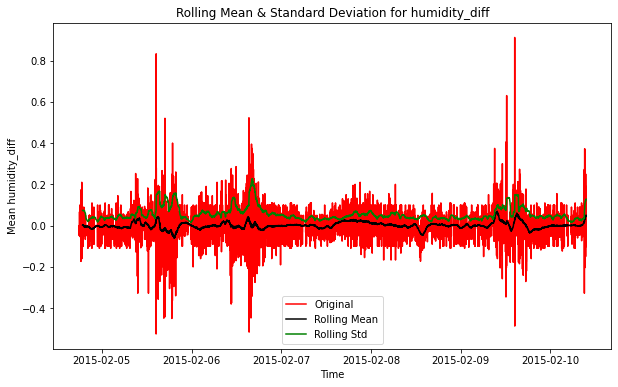

In [231]:
# is the mean constant? Yes
# is the variance constant? Yes
check_mean_std(ts_diff, 'humidity_diff')

In [232]:
adf_series.index.insert(0, 'Feature Name')
adf_series['Feature Name'] = 'humidity_diff'
adf = adf.append(adf_series, ignore_index=True)

### Light.

In [233]:
# is the Test Statistic value less than the 1% critical value? Yes
ts = df['light'].dropna()
check_adf(ts)

Test Statistic            -3.314600
p-value                    0.014200
Lags Used                 30.000000
Observations Used       8112.000000
Critical Value at 1%      -3.431156
dtype: float64

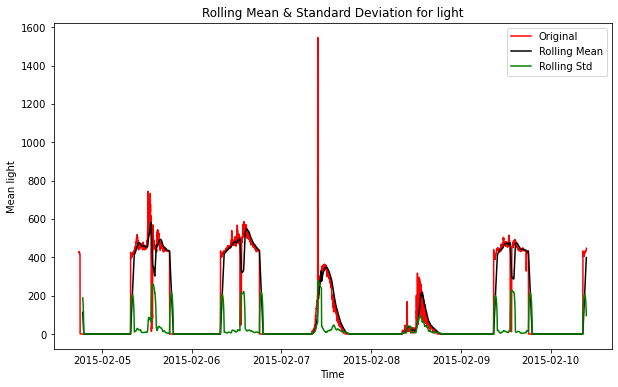

In [234]:
# is the mean constant? No
# is the variance constant? No
check_mean_std(ts, 'light')

In [235]:
ts = df['light']
ts_diff = ts.diff()

In [236]:
# is the Test Statistic value less than the 1% critical value? Yes
adf_series = check_adf(ts_diff.dropna())
adf_series

Test Statistic           -20.665900
p-value                    0.000000
Lags Used                 29.000000
Observations Used       8112.000000
Critical Value at 1%      -3.431156
dtype: float64

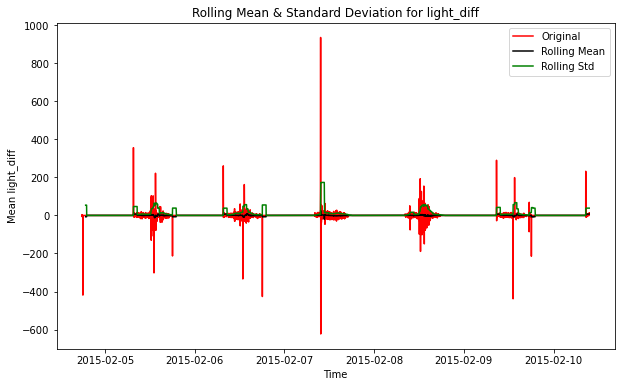

In [237]:
# is the mean constant? No
# is the variance constant? No
check_mean_std(ts_diff, 'light_diff')

In [238]:
adf_series.index.insert(0, 'Feature Name')
adf_series['Feature Name'] = 'light_diff'
adf = adf.append(adf_series, ignore_index=True)

### CO2.

In [239]:
# is the Test Statistic value less than the 1% critical value? No
ts = df['co2'].dropna()
check_adf(ts)

Test Statistic            -3.639000
p-value                    0.005100
Lags Used                 35.000000
Observations Used       8107.000000
Critical Value at 1%      -3.431157
dtype: float64

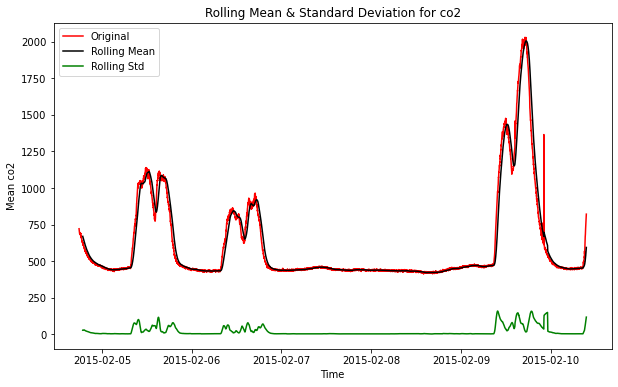

In [240]:
# is the mean constant? No
# is the variance constant? No
check_mean_std(ts, 'co2')

In [241]:
ts = df['co2']
ts_diff = ts.diff()

In [242]:
# is the Test Statistic value less than the 1% critical value? Yes
adf_series = check_adf(ts_diff.dropna())
adf_series

Test Statistic            -6.671700
p-value                    0.000000
Lags Used                 34.000000
Observations Used       8107.000000
Critical Value at 1%      -3.431157
dtype: float64

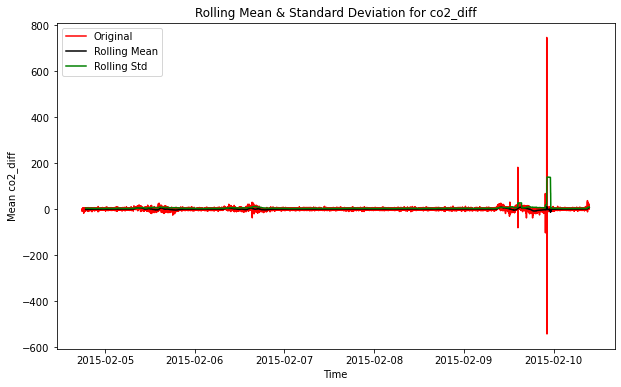

In [243]:
# is the mean constant? Yes
# is the variance constant? Yes
# they are constant, for the most part
check_mean_std(ts_diff, 'co2_diff')

In [244]:
adf_series.index.insert(0, 'Feature Name')
adf_series['Feature Name'] = 'co2_diff'
adf = adf.append(adf_series, ignore_index=True)

### Humidity Ratio.

In [245]:
# is the Test Statistic value less than the 1% critical value? No
ts = df['humidity_ratio'].dropna()
check_adf(ts)

Test Statistic            -1.279700
p-value                    0.638400
Lags Used                 27.000000
Observations Used       8115.000000
Critical Value at 1%      -3.431156
dtype: float64

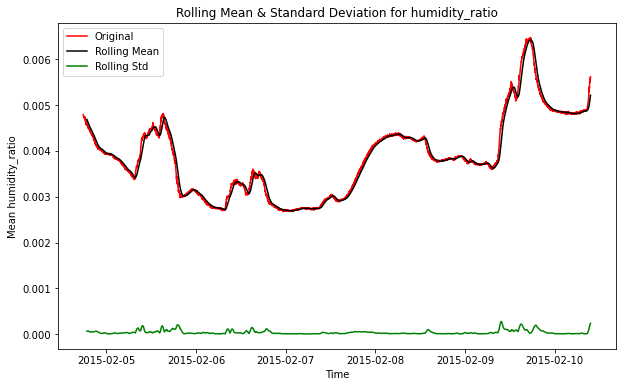

In [246]:
# is the mean constant? No
# is the variance constant? Yes
check_mean_std(ts, 'humidity_ratio')

In [247]:
ts = df['humidity_ratio']
ts_diff = ts.diff()

In [248]:
# is the Test Statistic value less than the 1% critical value? Yes
adf_series = check_adf(ts_diff.dropna())
adf_series

Test Statistic            -8.032400
p-value                    0.000000
Lags Used                 26.000000
Observations Used       8115.000000
Critical Value at 1%      -3.431156
dtype: float64

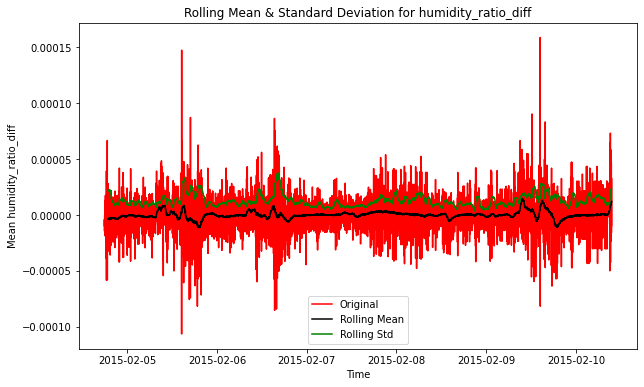

In [249]:
# is the mean constant? Yes
# is the variance constant? Yes
check_mean_std(ts_diff, 'humidity_ratio_diff')

In [250]:
adf_series.index.insert(0, 'Feature Name')
adf_series['Feature Name'] = 'humidity_ratio_diff'
adf = adf.append(adf_series, ignore_index=True)

### Add stationary features to the dataset.

In [251]:
df['temperature_diff'] = df['temperature'].diff()
df['humidity_diff'] = df['humidity'].diff()
df['light_diff'] = df['light'].diff()
df['co2_diff'] = df['co2'].diff()
df['humidity_ratio_diff'] = df['humidity_ratio'].diff()

### View summary of stationary features and new structure of the dataset.

In [252]:
adf

,Feature Name,Test Statistic,p-value,Lags Used,Observations Used,Critical Value at 1%
0,temperature_diff,-12.0586,0.0,20.0,8121.0,-3.431155
1,humidity_diff,-7.6978,0.0,36.0,8105.0,-3.431157
2,light_diff,-20.6659,0.0,29.0,8112.0,-3.431156
3,co2_diff,-6.6717,0.0,34.0,8107.0,-3.431157
4,humidity_ratio_diff,-8.0324,0.0,26.0,8115.0,-3.431156


In [253]:
df.head()

,temperature,humidity,light,co2,humidity_ratio,occupancy,temperature_diff,humidity_diff,light_diff,co2_diff,humidity_ratio_diff
date,,,,,,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,NaN,NaN,NaN,NaN,NaN
2015-02-04 17:52:00,23.15,27.2675,429.5,714.00,0.004783,1,-0.03,-0.0045,3.5,-7.25,-0.000010
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,0.00,-0.0225,-3.5,-0.50,-0.000004
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,0.00,-0.0450,0.0,-5.25,-0.000008
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,-0.05,0.0000,0.0,-3.75,-0.000015


### ARIMA model.

In [254]:
train, test = train_test_split(df['light'], test_size = 0.1, shuffle=False)

In [255]:
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

for p in range(5):
    for q in range(5):
            arima = ARIMA(endog=train, order=(p, 1, q))
            model = arima.fit()
            aic = model.aic
            if aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q
                
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(4,1,3).
This model has an AIC of 66031.78676159307.


In [256]:
model = ARIMA(endog=train, order=(best_p, 1, best_q))
arima = model.fit()

In [257]:
preds = model.predict(params=arima.params, start=test.index[0], end=test.index[-1])

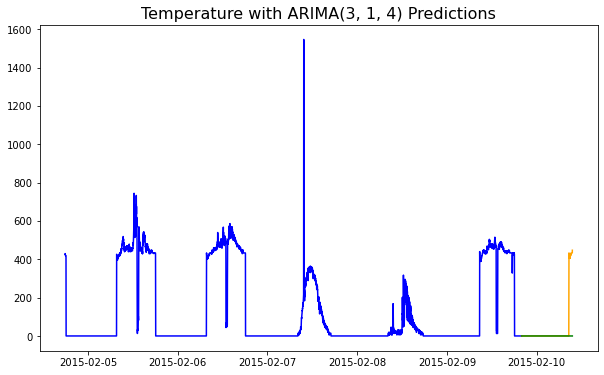

In [258]:
plt.figure(figsize=(10,6))
plt.plot(train.index, pd.DataFrame(train), color = 'blue')
plt.plot(test.index, pd.DataFrame(test), color = 'orange')
plt.plot(test.index, preds, color = 'green')
plt.title(label = 'Temperature with ARIMA(3, 1, 4) Predictions', fontsize=16)
plt.show();

### VAR model.

In [286]:
df.columns

Index(['temperature', 'humidity', 'light', 'co2', 'humidity_ratio',
       'occupancy', 'temperature_diff', 'humidity_diff', 'light_diff',
       'co2_diff', 'humidity_ratio_diff'],
      dtype='object')

In [287]:
stat_df = df[['temperature_diff', 'humidity_diff', 'light_diff',
              'co2_diff', 'humidity_ratio_diff']].copy()

In [288]:
stat_df.dropna(inplace=True)

In [289]:
train, test = train_test_split(stat_df, test_size=0.25, shuffle=False)

In [290]:
model = VAR(train)

In [291]:
ts_model = model.fit(maxlags=15, ic='aic')

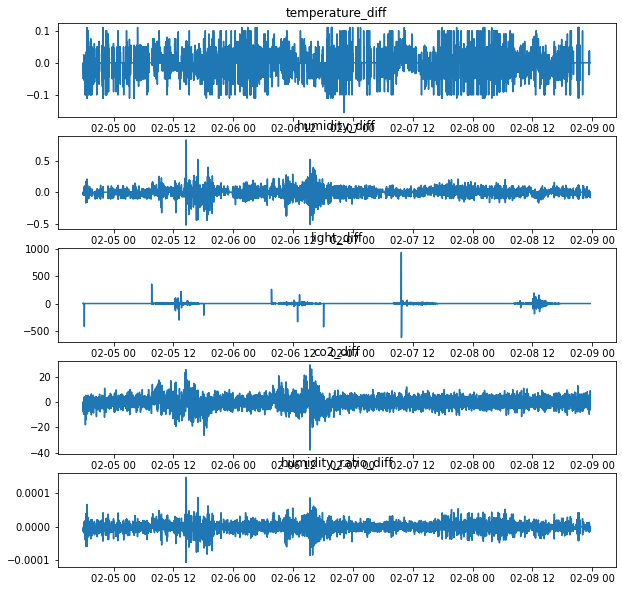

In [292]:
ts_model.plot();

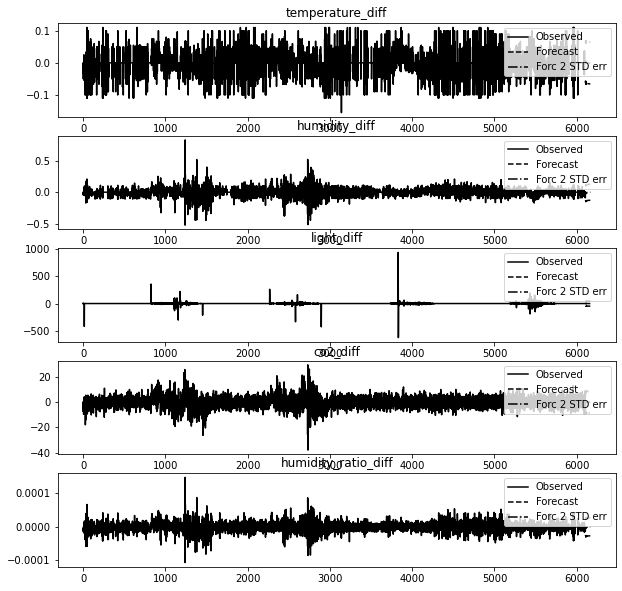

In [293]:
ts_model.plot_forecast(60);

In [294]:
preds = ts_model.forecast(test.values, len(test))

In [295]:
true = test.values

In [296]:
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], preds[:, i]), 4)}')

The test MSE on the temperature_diff data is: 0.0011
The test MSE on the humidity_diff data is: 0.0045
The test MSE on the light_diff data is: 283.4587
The test MSE on the co2_diff data is: 617.2994
The test MSE on the humidity_ratio_diff data is: 0.0


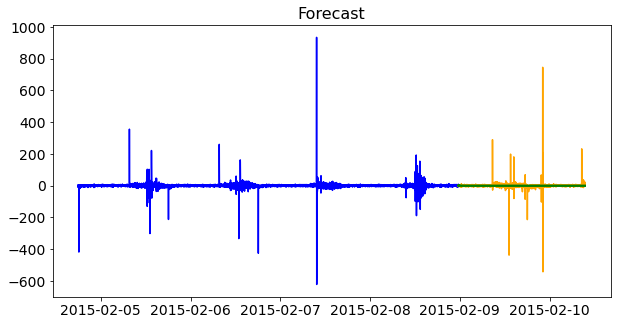

In [298]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train.values, color = 'blue')
plt.plot(test.index, true, color = 'orange')
plt.plot(test.index, preds, color = 'green')
plt.title(label = 'Forecast', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);